# Part IV: Validation and Testing

Date: 23/08/2022

Authors: Jordi Bolibar & Facundo Sapienza

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Setup

The goal of this notebook is to explore different validation and testing methodologies that you can use and the respective considerations you have to consider at the moment of asserting the performace of a given model, either for model selection or test report. 

When training and testing a model, we usually split the dataset among three different sets: training, validation and testing set. Sometimes, this split of the data is done authomatically by the method we use, and sometimes instead of a simple split of the dataset into three pieces is done iteratively (eg, in k-fold cross-validation). Independently of how we implement this, we need to understand the limitations and considerations we need to have at the moment we do the split. This considerations can include:
- Sampling procedure
- Spatial and temporal correlations between data points
- Size of data available
- Nature of the datasets: where are they coming from? How independent they are?

### [ **Exercice 3** ]
<img src="Figures/eye_logo.png" width="75"/>

How would you desing a validation-testing workflow for the problem of predicting the mass balance? How would you divide the different folds?

For an excellent introduction to cross-validation, as well as the different high-level function to implement it in `sklearn` models, checkout [this tutorial](https://scikit-learn.org/stable/modules/cross_validation.html). 

halo

In [3]:
# Import training data
df_train_all = pd.read_csv('Data/df_train_all.csv', index_col=['rgi_id', 'period'])
df_train_all

PDD   area  icecap     lat     lon  \
rgi_id         period                                                
RGI60-08.00855 2000-2010  49.772800  0.754     0.0  61.752   8.174   
               2010-2020  48.806800  0.754     0.0  61.752   8.174   
RGI60-08.00284 2000-2010  50.198113  1.036     0.0  66.546  14.497   
               2010-2020  50.039557  1.036     0.0  66.546  14.497   
RGI60-08.01518 2000-2010  40.302047  0.050     0.0  66.790  14.553   
...                             ...    ...     ...     ...     ...   
RGI60-08.01174 2010-2020  55.879846  0.353     0.0  61.861   7.230   
RGI60-08.01690 2000-2010  38.201666  0.149     0.0  60.736   7.280   
               2010-2020  37.443333  0.149     0.0  60.736   7.280   
RGI60-08.03155 2000-2010  41.706430  0.133     0.0  65.368  13.133   
               2010-2020  41.360007  0.133     0.0  65.368  13.133   

                             prcp_01     prcp_02     prcp_03     prcp_04  \
rgi_id         period                                                      
RGI60-08.00855 2000-2010   98.155992   97.431399   93.727513  101.434631   
               2010-2020   95.760616   83.802870   97.767036   78.083405   
RGI60-08.00284 2000-2010  177.556147  195.367397  198.264223  195.481022   
               2010-2020  194.973485  157.806579  212.347313  139.825914   
RGI60-08.01518 2000-2010  171.017577  183.719187  187.798943  183.491316   
...                              ...         ...         ...         ...   
RGI60-08.01174 2010-2020  149.216654  132.893787  178.609721  128.084938   
RGI60-08.01690 2000-2010  171.013151  149.865191  152.839703  160.394624   
               2010-2020  158.911092  129.544313  157.749670  120.959889   
RGI60-08.03155 2000-2010  166.893368  178.875896  183.545535  189.663024   
               2010-2020  175.075336  143.109660  202.132780  138.779159   

                             prcp_05  ...   temp_09    temp_10    temp_11  \
rgi_id         period                 ...                                   
RGI60-08.00855 2000-2010   65.590466  ...  9.704667  12.418000  11.544666   
               2010-2020   59.111968  ...  9.514667  12.138000  11.264666   
RGI60-08.00284 2000-2010  148.502981  ...  8.828889  12.234816  11.557778   
               2010-2020  133.978220  ...  8.463333  11.963704  11.344445   
RGI60-08.01518 2000-2010  141.239106  ...  7.373111  10.870890  10.212000   
...                              ...  ...       ...        ...        ...   
RGI60-08.01174 2010-2020   99.625573  ...  9.858001  12.441334  11.866888   
RGI60-08.01690 2000-2010  100.742037  ...  7.516665  10.193334   9.736666   
               2010-2020   90.256486  ...  7.406665   9.923335   9.396666   
RGI60-08.03155 2000-2010  135.806936  ...  7.763851  10.810149  10.450518   
               2010-2020  124.610193  ...  7.467185  10.635704  10.251629   

                           temp_12    zmax    zmed    zmin  dmdtda  \
rgi_id         period                                                
RGI60-08.00855 2000-2010  7.168000  1923.0  1822.0  1751.0 -0.3601   
               2010-2020  7.378000  1923.0  1822.0  1751.0 -0.2904   
RGI60-08.00284 2000-2010  7.490000  1277.0  1151.0  1070.0 -1.0001   
               2010-2020  8.235556  1277.0  1151.0  1070.0  0.1495   
RGI60-08.01518 2000-2010  6.008667  1036.0  1019.0   996.0  0.2634   
...                            ...     ...     ...     ...     ...   
RGI60-08.01174 2010-2020  8.385778  1733.0  1630.0  1576.0 -0.5223   
RGI60-08.01690 2000-2010  5.746666  1579.0  1543.0  1500.0 -0.7835   
               2010-2020  5.956666  1579.0  1543.0  1500.0 -0.1401   
RGI60-08.03155 2000-2010  6.195704   973.0   939.0   919.0 -0.0454   
               2010-2020  6.833481   973.0   939.0   919.0 -0.3131   

                          err_dmdtda  target_id  
rgi_id         period                            
RGI60-08.00855 2000-2010      0.2903     1708.0  
               2010-2020      0.3110     1709.0  
RGI60-08.00284 2000

In [4]:
# Get features and mass_balance for cross-validation
features_to_drop = ['dmdtda', 'err_dmdtda', 'target_id']

df_train_X = df_train_all.drop(features_to_drop, axis=1)
df_train_y = df_train_all[['dmdtda']]

X_train, y_train = df_train_X.values, df_train_y.values

In [20]:
def plot_prediction(y1, y2, n_toplot=10**10):
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    plt.figure(figsize=(8,8))
    plt.title("Model Evaluation", fontsize=17)
    plt.ylabel('Modeled SMB (m.w.e)', fontsize=16)
    plt.xlabel('Reference SMB (m.w.e)', fontsize=16)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=20)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    plt.colorbar(sc) 
    lineStart = -2.5
    lineEnd = 1.5
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

In [26]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [29]:
xgb_model = xgb.XGBRegressor()

clf = GridSearchCV(xgb_model, {'max_depth': [2, 4, 6, 8],
                               'n_estimators': [50, 100, 200, 300],
                              'learning_rate': [0.01, 0.05, 0.1, 0.2]}, 
                   cv=10,
                   verbose=1,
                   n_jobs=4,
                   scoring='neg_mean_squared_error')
clf.fit(X_train, y_train)

print(clf.best_score_)
print(clf.best_params_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits
-0.08117700430518841
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [31]:
dtrain = xgb.DMatrix(X_train, label=y_train)
param = {'max_depth':4, 'learning_rate':0.1, 'n_estimators': 100}
num_round = 2

In [40]:
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.model_selection import cross_val_score

xgb_model = xgb.XGBRegressor(max_depth = 4,
                             n_estimators = 100,
                             learning_rate = 0.1)
#res = xgb.cv(param, dtrain, nfold=10,
#             metrics={'error'})#, #seed=0,
             #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=False),
             #           xgb.callback.EarlyStopping(3)])
        
#from sklearn.model_selection import cross_val_score
#from sklearn.model_selection import KFold

# define model evaluation method
#cv = KFold(n_splits=10, random_state=1)
# evaluate model
#scores = cross_val_score(xgb_model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
#scores = absolute(scores)
#print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

print(cross_val_score(xgb_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))

y_pred = cvp(xgb_model, X_train, y_train, cv=10, n_jobs = 2)#, fit_params = param)

#xgb_model.fit(X_train, y_train)


[-0.07069001 -0.08343747 -0.07721034 -0.09419244 -0.09286963 -0.08260603
 -0.07224338 -0.07476126 -0.06845785 -0.09530163]


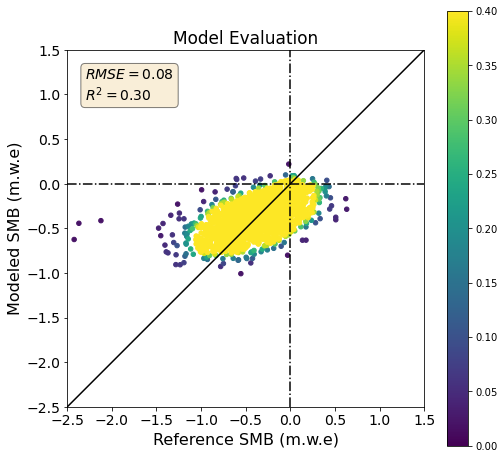

In [41]:
plot_prediction(y_train, y_pred, n_toplot=5000)

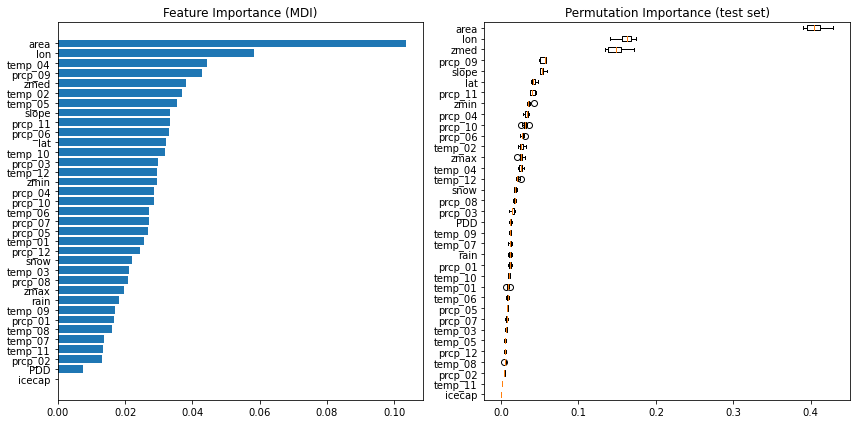

In [45]:
#sorted_idx = xgb_model.feature_importances_.argsort()
#plt.barh(boston.feature_names[sorted_idx], xgb_model.feature_importances_[sorted_idx])
#plt.xlabel("Xgboost Feature Importance")
from sklearn.inspection import permutation_importance


xgb_model.fit(X_train, y_train)
feature_importance = xgb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(df_train_X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    xgb_model, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(df_train_X.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()